In [1]:
import requests_cache
requests_cache.install_cache('cache', allowable_codes=[200, 404], allowable_methods=['GET', 'POST'])
import requests
import pandas as pd
from tqdm.auto import tqdm
import json
pd.set_option("display.max_columns", None)

price_history = pd.read_csv("price_history.csv")
price_history.sort_values(price_history.columns.tolist(), inplace=True)

all_products = []
new_prices = []
for page in tqdm(range(1, 84)):
    try:
        r = requests.get("https://www.woolworths.co.nz/api/v1/products", params={
            "target": "browse",
            "inStockProductsOnly": "false",
            "size": 120,
            "page": page
        }, headers={
            "x-requested-with": "??",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
        }, timeout=5)
        r.raise_for_status()
        timestamp = int(r.created_at.timestamp())
        products = r.json()["products"]["items"]
        assert len(products) > 0, "No products"
        for product in products:
            sku = int(product["sku"])
            prices = price_history[price_history.SKU == sku].price
            if len(prices) == 0:
                last_price = None
            else:
                last_price = prices.iloc[-1]
            if product["price"]["salePrice"] != last_price:
                print(f"SKU {sku} price changed from {last_price} to {product['price']['salePrice']}")
                new_prices.append({
                    "SKU": sku,
                    "timestamp": timestamp,
                    "price": product["price"]["salePrice"]
                })
        all_products.extend(products)
    except Exception as e:
        raise
df = pd.json_normalize(all_products)
df.to_csv("products.csv", index=False)
df

  0%|          | 0/83 [00:00<?, ?it/s]

SKU 336058 price changed from 6.0 to 6.5
SKU 611548 price changed from 4.8 to 5.2
SKU 346500 price changed from 5.5 to 6.0
SKU 567608 price changed from 6.0 to 6.6
SKU 292795 price changed from 6.0 to 6.5
SKU 283186 price changed from 7.5 to 8.0
SKU 377912 price changed from None to 10.99
SKU 166305 price changed from 5.5 to 4.95
SKU 391543 price changed from 12.99 to 7.99
SKU 947620 price changed from None to 7.0
SKU 463666 price changed from None to 6.8
SKU 314047 price changed from None to 8.5
SKU 125302 price changed from 5.49 to 5.0
SKU 385328 price changed from None to 7.79
SKU 920884 price changed from None to 6.9
SKU 682708 price changed from None to 9.0
SKU 24570 price changed from 7.1 to 5.39
SKU 248520 price changed from 24.89 to 19.9
SKU 149307 price changed from None to 7.9
SKU 795650 price changed from 5.0 to 3.5
SKU 222602 price changed from 2.3 to 2.0
SKU 777103 price changed from None to 8.5


,type,name,barcode,variety,brand,slug,sku,unit,selectedPurchasingUnit,stockLevel,eachUnitQuantity,averageWeightPerUnit,hasShopperNotes,productTag,departments,subsAllowed,supportsBothEachAndKgPricing,adId,brandSuggestionId,brandSuggestionName,priceUnitLabel,availabilityStatus,onlineSample,onlineSampleRealProductMapId,price.originalPrice,price.salePrice,price.savePrice,price.savePercentage,price.canShowSavings,price.hasBonusPoints,price.isClubPrice,price.isSpecial,price.isNew,price.canShowOriginalPrice,price.discount,price.total,price.isTargetedOffer,price.averagePricePerSingleUnit,price.isBoostOffer,price.purchasingUnitPrice,price.orderedPrice,price.isUsingOrderedPrice,price.currentPricingMatchesOrderedPricing,price.extendedListPrice,price.originalAveragePricePerSingleUnit,images.small,images.big,quantity.min,quantity.max,quantity.increment,quantity.value,quantity.quantityInOrder,quantity.purchasingQuantityString,size.cupListPrice,size.cupPrice,size.cupMeasure,size.packageType,size.volumeSize,productTag.tagType,productTag.multiBuy,productTag.bonusPoints,productTag.additionalTag.name,productTag.additionalTag.link,productTag.additionalTag.imagePath,productTag.additionalTag.linkTarget,productTag.additionalTag.altText,productTag.targetedOffer,productTag.boostOffer,productTag.additionalTag,productTag.multiBuy.quantity,productTag.multiBuy.value,productTag.multiBuy.link,productTag.multiBuy.multiCupValue
0,Product,fresh fruit bananas yellow,9354829000064,yellow,fresh fruit,fresh-fruit-bananas-yellow,133211,Kg,None,3,None,0.25,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,3.49,3.49,0.0,0.0,True,False,False,False,False,True,None,None,False,0.87,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.2,100.0,0.2,None,None,None,3.49,3.49,1kg,loose,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Product,fresh vegetable cucumbers telegraph,9421901390013,telegraph,fresh vegetable,fresh-vegetable-cucumbers-telegraph,281455,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,In Stock,None,0,1.50,1.50,0.0,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,3.19,1.50,1ea,,,Other,NaN,NaN,Fresh Deals,,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Product,woolworths butter salted,9300633725082,salted,woolworths,woolworths-butter-salted,827847,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,7.19,7.19,0.0,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/8...,https://assets.woolworths.com.au/images/2010/8...,1.0,4.0,1.0,None,None,None,1.44,1.44,100g,None,500g,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Product,fresh vegetable carrots,9414742351053,,fresh vegetable,fresh-vegetable-carrots,135344,Kg,None,3,None,0.15,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,2.50,2.50,0.0,0.0,True,False,False,False,False,True,None,None,False,0.38,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.1,100.0,0.1,None,None,None,2.99,2.50,1kg,loose,per kg,Other,NaN,NaN,Fresh Deals,,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Product,woolworths milk standard,9414742036509,standard,woolworths,woolworths-milk-standard,282768,Each,None,3,None,NaN,None,NaN,"[{'id': 17, 'name': 'Easter'}]",False,False,None,None,None,None,In Stock,None,0,6.75,6.75,0.0

In [2]:
price_history = pd.concat([price_history, pd.DataFrame(new_prices)], ignore_index=True).sort_values(price_history.columns.tolist())
price_history

,SKU,timestamp,price
0,25,1728880327,3.99
1,168,1728880353,2.60
2,326,1728880348,4.30
3,579,1728880353,1.00
4,579,1729443688,2.00
...,...,...,...
86083,6000520,1737306150,12.49
86084,6000520,1737910881,11.00
86085,6000613,1738083905,11.50
86086,6003489,1737997424,8.00


In [3]:
price_history.groupby("SKU").size().value_counts()

1     2634
14    1289
15     786
2      714
13     697
3      697
12     604
9      596
11     545
10     481
7      443
8      431
5      397
6      356
4      342
16     221
17      99
18      18
21       2
20       1
dtype: int64

In [4]:
delta = price_history.groupby("SKU").price.diff()
delta.describe()

count    74757.000000
mean         0.012039
std          2.486821
min        -28.990000
25%         -1.090000
50%          0.000000
75%          1.090000
max         28.990000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

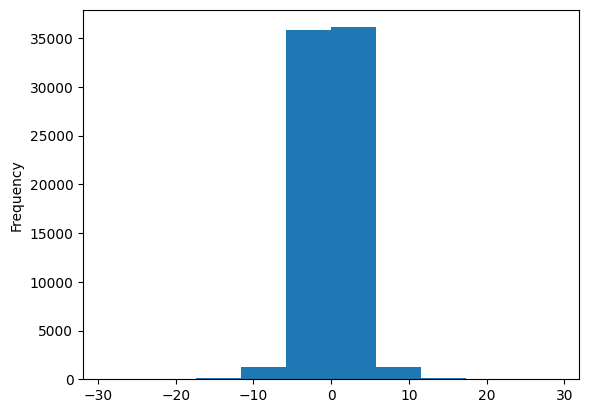

In [5]:
delta.plot.hist()

In [6]:
price_history.to_csv("price_history.csv", index=False)